In [1]:
import gpmultipy, scipy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from gpmultipy import dataset
from gpmultipy.model import Model
from gpmultipy.prior import Prior
from gpmultipy.kernel import RBF, White, Addition
from gpmultipy.freeze import Freezer
from gpmultipy.sampler.slice import Slice
from gpmultipy.kernel import Product, Linear

In [3]:
%matplotlib inline

In [4]:
def printSample(sample,depth=1):
    keys = sample.keys()
    keys.sort()
    
    for k in keys:
        if type(sample[k]) == dict:
            print "\t".join([""]*depth) + k
            printSample(sample[k],depth=depth+1)
        else:
            print "\t".join([""]*depth) + "%s: %s"%(k,str(sample[k]))

In [5]:
ds = dataset.DataSet('data/')
x,y,effect,labels = ds.build(Strain='ura3',mM_PQ=0.0,scale='range',effects=['Well'])
y = np.log2(y)
y = (y-y.mean())/y.std()

In [6]:
edge = range(101,111) + range(111,191,10) + range(120,191,10) + range(191,201) + range(201,211) + range(211,291,10) + range(220,291,10) + range(291,301)
edge = np.array(edge)
edge

array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 121, 131,
       141, 151, 161, 171, 181, 120, 130, 140, 150, 160, 170, 180, 190,
       191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203,
       204, 205, 206, 207, 208, 209, 210, 211, 221, 231, 241, 251, 261,
       271, 281, 220, 230, 240, 250, 260, 270, 280, 290, 291, 292, 293,
       294, 295, 296, 297, 298, 299, 300])

In [7]:
dist = np.array([min(abs(l-edge)) for l in labels[0]])
position = (dist==0).astype(int)

In [9]:
yKernel = White(1,.1)
k1 = RBF(1,1,1)
k2 = RBF(1,1,1)

# yKernel = White(1,1)
# k1 = RBF(1,1,1)

p = y.shape[1]
dm = np.ones((2,p))
dm[1,:] = 1-2*position
# dm[1,:] = position

prior = Prior(x,k1,[0])
prior2 = Prior(x,k2,range(1,dm.shape[0]))

model = Model(x,y,dm)

In [10]:
ySigmaSlice = Slice('ySigma',
                    lambda x: model.dataLikelihood(yKernel,sigma=x),
                    lambda x: scipy.stats.lognorm(1,scale=1e-0).logpdf(x),
                    .2,5,logspace=True)

kSigmaSlice = Slice('kSigma',
                    lambda x: prior.loglikelihood(model.beta,sigma=x),
                    lambda x: scipy.stats.uniform(1e-2,1e2).logpdf(x),
                    .2,5,logspace=True)

kLengthscaleSlice = Slice('kLengthscale',
                    lambda x: prior.loglikelihood(model.beta,lengthscale=x),
                    lambda x: scipy.stats.uniform(1e-2,1e2).logpdf(x),
                    .2,5,logspace=True)

k2SigmaSlice = Slice('kSigma',
                    lambda x: prior2.loglikelihood(model.beta,sigma=x),
                    lambda x: scipy.stats.uniform(1e-2,1e2).logpdf(x),
                    .2,5,logspace=True)

k2LengthscaleSlice = Slice('kLengthscale',
                    lambda x: prior2.loglikelihood(model.beta,lengthscale=x),
                    lambda x: scipy.stats.uniform(1e-2,1e2).logpdf(x),
                    .2,5,logspace=True)

samples = []
freeze = Freezer(yKernel=yKernel,k1=k1,k2=k2,model=model)

In [11]:
thin = 10
burnin = 0
nsample = 3000

for i in range(nsample):
    prior.sample(model,yKernel)
    prior2.sample(model,yKernel)
    
    yKernel.sigma = ySigmaSlice.sample(yKernel.sigma)
    
    k1.sigma = kSigmaSlice.sample(k1.sigma)
    k1.lengthscale = kLengthscaleSlice.sample(k1.lengthscale)
    
    k2.sigma = k2SigmaSlice.sample(k2.sigma)
    k2.lengthscale = k2LengthscaleSlice.sample(k2.lengthscale)

    if i % thin == 0 and i > burnin:
        f = freeze.freeze()
        del f['model']
        
        print "~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~"
        print model.dataLikelihood(yKernel)
        printSample(f)
        print
        
        samples.append(freeze.freeze())

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
5986.20299928
k1
	lengthscale: 0.141253895313
	sigma: 0.0197080822145
k2
	lengthscale: 0.141002681832
	sigma: 0.0216296706316
yKernel
	sigma: 0.0277584306019

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
5974.60802533
k1
	lengthscale: 0.151023369968
	sigma: 0.0236078261596
k2
	lengthscale: 0.155071241568
	sigma: 0.0206581327672
yKernel
	sigma: 0.0285092552838

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
5977.97075578
k1
	lengthscale: 0.153675890311
	sigma: 0.0216255206244
k2
	lengthscale: 0.148661415329
	sigma: 0.0203781286674
yKernel
	sigma: 0.0277066465022

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
5967.53826822
k1
	lengthscale: 0.163589833006
	sigma: 0.0196301627243
k2
	lengthscale: 0.160063822089
	sigma: 0.0248798722019
yKernel
	sigma: 0.0288420487743

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
5963.21509978
k1
	lengthscale: 0.166831091259
	sigma: 0.0189659890587
k2
	lengthscale: 0.161233460037
	sigma: 0.0251447906534
yKernel
	sigma: 0.0281402762785

~~~~~

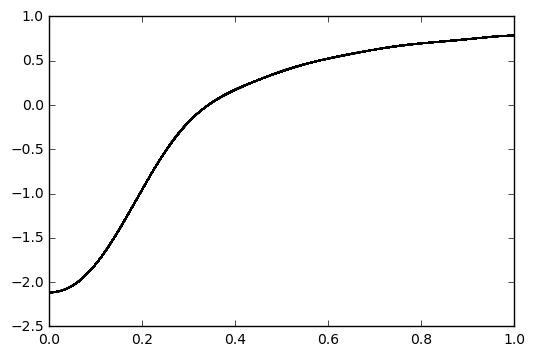

In [12]:
plt.plot(x,np.array([s['model']['beta'][:,0] for s in samples]).T,c='k',alpha=.5);

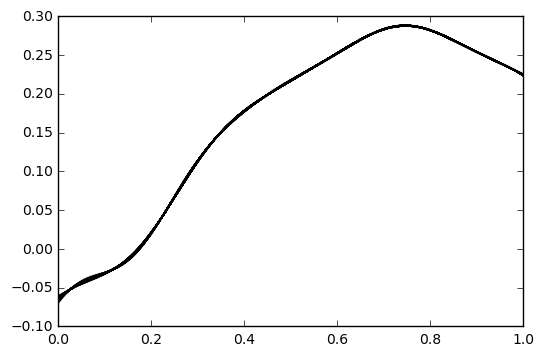

In [13]:
plt.plot(x,np.array([s['model']['beta'][:,1] for s in samples]).T,c='k',alpha=.5);

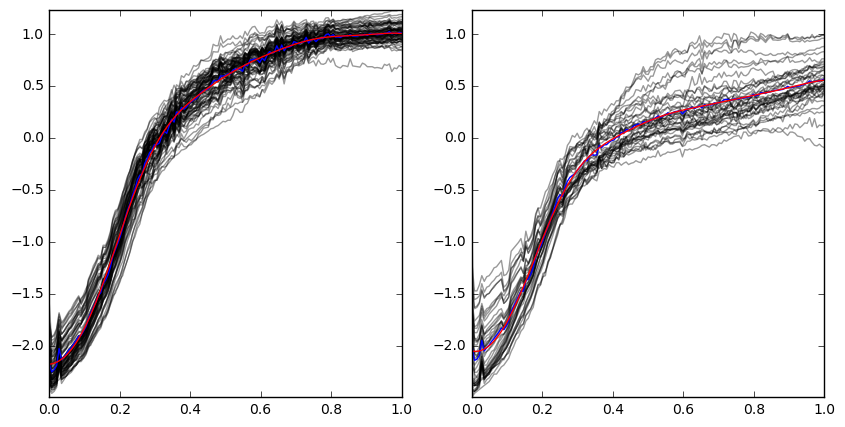

In [14]:
beta = samples[-1]['model']['beta']

plt.figure(figsize=(10,5))
for i,p in enumerate([0,1]):
    select = position==p
    
    plt.subplot(1,2,i+1)
    plt.plot(x,y[:,select],c='k',alpha=.4)
    plt.plot(x,y[:,select].mean(1),c='b',alpha=1)
    plt.plot(x,beta[:,0] + (1-2*p)*beta[:,1],c='r')
    
    plt.ylim(y.min(),y.max())

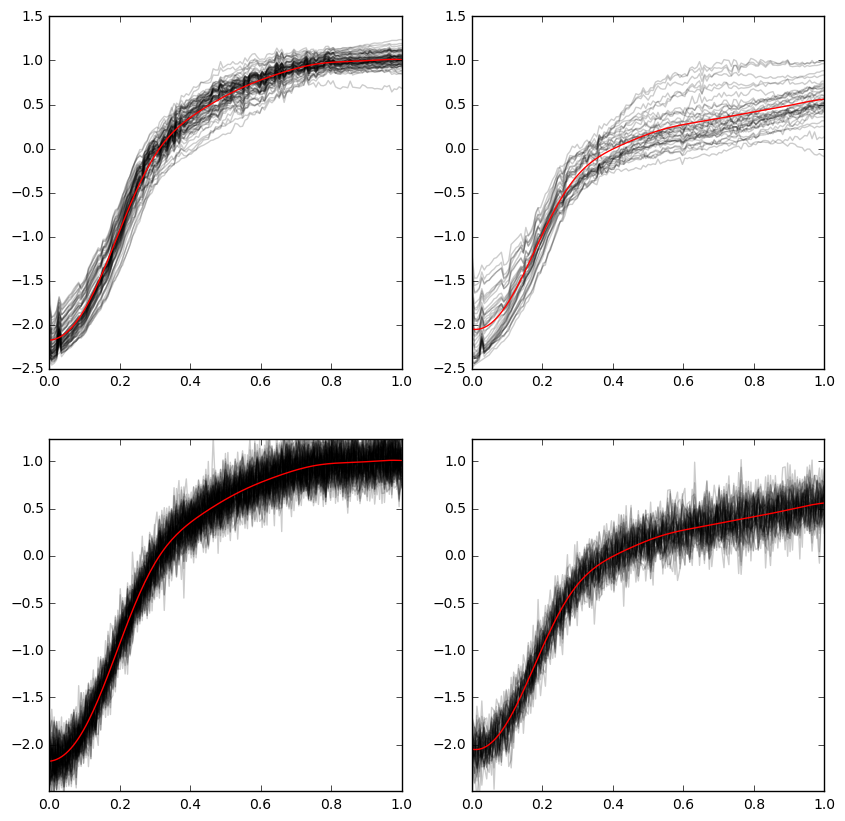

In [15]:
beta = samples[-1]['model']['beta']

plt.figure(figsize=(10,10))
for i,p in enumerate([0,1]):
    select = position==p
    
    plt.subplot(2,2,i+1)
    plt.plot(x,y[:,select],c='k',alpha=.2)
    plt.plot(x,beta[:,0] + (1-2*p)*beta[:,1],c='r')
    
    plt.subplot(2,2,i+3)
    sample = scipy.stats.multivariate_normal.rvs(beta[:,0] + (1-2*p)*beta[:,1],yKernel.K(x),size=sum(select)).T
    plt.plot(x,sample,c='k',alpha=.2)
    plt.plot(x,beta[:,0] + (1-2*p)*beta[:,1],c='r')
    plt.ylim(y.min(),y.max())